In [16]:
from pathlib import Path  # ← add this line
import shutil
import cv2

def convert_wider_face(txt_path, image_root, output_dir):
    img_save = Path(output_dir) / 'images'
    label_save = Path(output_dir) / 'labels'
    img_save.mkdir(parents=True, exist_ok=True)
    label_save.mkdir(parents=True, exist_ok=True)

    with open(txt_path, 'r') as f:
        lines = f.read().splitlines()

    i = 0
    total_converted = 0
    while i < len(lines):
        # Skip any empty lines
        while i < len(lines) and lines[i].strip() == '':
            i += 1
        if i >= len(lines):
            break

        # This line must be a filename ending in .jpg
        line = lines[i].strip()
        if not line.endswith('.jpg'):
            i += 1  # skip junk lines like "0 0 0 0 0 0 0 0 0 0"
            continue

        filename = line
        i += 1

        if i >= len(lines):
            break

        try:
            face_count = int(lines[i].strip())
        except ValueError:
            print(f"[ERROR] Expected face count but got: {lines[i]}")
            i += 1
            continue
        i += 1

        img_path = Path(image_root) / filename
        dst_img_path = img_save / filename
        dst_img_path.parent.mkdir(parents=True, exist_ok=True)

        if not img_path.exists():
            print(f"[SKIP] Missing image: {img_path}")
            i += face_count
            continue

        img = cv2.imread(str(img_path))
        if img is None:
            print(f"[SKIP] Failed to load image: {img_path}")
            i += face_count
            continue

        h, w = img.shape[:2]
        shutil.copy(img_path, dst_img_path)

        labels = []
        for _ in range(face_count):
            if i >= len(lines):
                break
            parts = lines[i].strip().split()
            i += 1
            if len(parts) < 4:
                continue
            x, y, bw, bh = map(float, parts[:4])
            if bw <= 0 or bh <= 0:
                continue
            xc = (x + bw / 2) / w
            yc = (y + bh / 2) / h
            nw = bw / w
            nh = bh / h
            if xc > 1 or yc > 1:
                continue
            labels.append(f"0 {xc:.6f} {yc:.6f} {nw:.6f} {nh:.6f}")

        if labels:
            label_file = label_save / Path(filename).with_suffix('.txt')
            label_file.parent.mkdir(parents=True, exist_ok=True)
            with open(label_file, 'w') as f:
                f.write('\n'.join(labels))
            total_converted += 1

    print(f"✅ Done: {total_converted} images with valid labels saved to {output_dir}")

In [17]:
# rm -rf dataset/train dataset/val

In [18]:
convert_wider_face(
    txt_path='wider_face_split/wider_face_train_bbx_gt.txt',
    image_root='WIDER_train/images',
    output_dir='dataset/train'
)

convert_wider_face(
    txt_path='wider_face_split/wider_face_val_bbx_gt.txt',
    image_root='WIDER_val/images',
    output_dir='dataset/val'
)

✅ Done: 12876 images with valid labels saved to dataset/train
✅ Done: 3222 images with valid labels saved to dataset/val


In [19]:
yaml_content = """\
path: dataset
train: train/images
val: val/images

nc: 1
names: ['face']
"""

with open("wider.yaml", "w") as f:
    f.write(yaml_content)


In [20]:
# !yolo detect train model=yolov8n.pt data=wider.yaml epochs=100 imgsz=640 batch=16

In [21]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')
results = model.train(data='wider.yaml', epochs=50, imgsz=224, batch=32)

New https://pypi.org/project/ultralytics/8.3.161 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.160 🚀 Python-3.11.8 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce GTX 1070, 8111MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=wider.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, op

train: Scanning /home/nikola/Documents/DeepLearning-Assignment-7-2/dataset/train/labels/0--Parade.cache... 12876 images, 4 backgrounds, 0 corrupt: 100%|██████████| 12880/12880 [00:00<?, ?it/s]

train: /home/nikola/Documents/DeepLearning-Assignment-7-2/dataset/train/images/2--Demonstration/2_Demonstration_Protesters_2_231.jpg: 1 duplicate labels removed
train: /home/nikola/Documents/DeepLearning-Assignment-7-2/dataset/train/images/37--Soccer/37_Soccer_Soccer_37_851.jpg: 1 duplicate labels removed
train: /home/nikola/Documents/DeepLearning-Assignment-7-2/dataset/train/images/7--Cheering/7_Cheering_Cheering_7_17.jpg: 1 duplicate labels removed


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1787.3±1228.6 MB/s, size: 116.1 KB)


val: Scanning /home/nikola/Documents/DeepLearning-Assignment-7-2/dataset/val/labels/0--Parade.cache... 3222 images, 4 backgrounds, 0 corrupt: 100%|██████████| 3226/3226 [00:00<?, ?it/s]

val: /home/nikola/Documents/DeepLearning-Assignment-7-2/dataset/val/images/21--Festival/21_Festival_Festival_21_604.jpg: 1 duplicate labels removed


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.98G      2.072       1.46      1.176        144        224: 100%|██████████| 403/403 [01:17<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:15<00:00,  3.35it/s]


                   all       3226      39696      0.599      0.227      0.255       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.49G      1.789     0.9553       0.98        261        224: 100%|██████████| 403/403 [01:18<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:14<00:00,  3.63it/s]


                   all       3226      39696      0.642      0.242      0.272      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.88G      1.841      1.007     0.9839        185        224: 100%|██████████| 403/403 [01:16<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:14<00:00,  3.58it/s]


                   all       3226      39696      0.582      0.216      0.236      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.89G       1.86      1.046      1.002        259        224: 100%|██████████| 403/403 [01:16<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:14<00:00,  3.52it/s]


                   all       3226      39696      0.609      0.228      0.247      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.89G      1.796     0.9859     0.9872         98        224: 100%|██████████| 403/403 [01:16<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:14<00:00,  3.58it/s]


                   all       3226      39696      0.646      0.249      0.278      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.89G      1.741     0.9533     0.9746        242        224: 100%|██████████| 403/403 [01:16<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:14<00:00,  3.55it/s]


                   all       3226      39696      0.635      0.251      0.281      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.89G      1.714     0.9233     0.9698        220        224: 100%|██████████| 403/403 [01:16<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:14<00:00,  3.60it/s]


                   all       3226      39696      0.663      0.262      0.301      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.89G      1.684     0.9036     0.9679        196        224: 100%|██████████| 403/403 [01:16<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:14<00:00,  3.53it/s]


                   all       3226      39696       0.68      0.268        0.3      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.89G      1.643     0.8775     0.9586        228        224: 100%|██████████| 403/403 [01:16<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:14<00:00,  3.59it/s]


                   all       3226      39696      0.671      0.269      0.302      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.89G      1.639     0.8652     0.9529        148        224: 100%|██████████| 403/403 [01:16<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:14<00:00,  3.62it/s]


                   all       3226      39696      0.675      0.273      0.313      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.89G      1.614     0.8493     0.9507        342        224: 100%|██████████| 403/403 [01:16<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:14<00:00,  3.64it/s]


                   all       3226      39696      0.678      0.281      0.316      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.89G      1.602      0.841     0.9451        173        224: 100%|██████████| 403/403 [01:15<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.69it/s]


                   all       3226      39696      0.675       0.28      0.317      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.91G      1.582     0.8259     0.9486        266        224: 100%|██████████| 403/403 [01:15<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.72it/s]


                   all       3226      39696      0.695      0.282      0.324      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.91G      1.578     0.8223     0.9442        125        224: 100%|██████████| 403/403 [01:15<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.71it/s]


                   all       3226      39696      0.691      0.285       0.33      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.91G      1.571     0.8139     0.9393        172        224: 100%|██████████| 403/403 [01:15<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.73it/s]


                   all       3226      39696      0.692      0.286      0.328      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.91G      1.552      0.797     0.9384        115        224: 100%|██████████| 403/403 [01:15<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.71it/s]


                   all       3226      39696      0.702      0.289      0.336      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.91G      1.542     0.7916      0.935        140        224: 100%|██████████| 403/403 [01:15<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.70it/s]


                   all       3226      39696       0.69      0.294      0.331      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.91G      1.539     0.7903     0.9338        353        224: 100%|██████████| 403/403 [01:15<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.72it/s]


                   all       3226      39696      0.701      0.291      0.337      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.91G      1.518     0.7761      0.932        214        224: 100%|██████████| 403/403 [01:15<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.72it/s]


                   all       3226      39696      0.706      0.295      0.343      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.91G      1.517     0.7739     0.9327        145        224: 100%|██████████| 403/403 [01:15<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.74it/s]


                   all       3226      39696      0.716      0.293      0.341      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.91G      1.511     0.7651     0.9315        145        224: 100%|██████████| 403/403 [01:15<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.73it/s]


                   all       3226      39696      0.711      0.295      0.338      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.91G      1.507     0.7659     0.9306        193        224: 100%|██████████| 403/403 [01:15<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.73it/s]


                   all       3226      39696      0.719      0.299      0.346      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.91G      1.494     0.7572     0.9283        104        224: 100%|██████████| 403/403 [01:15<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.67it/s]


                   all       3226      39696      0.714        0.3      0.345      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.91G      1.489     0.7544     0.9263        139        224: 100%|██████████| 403/403 [01:15<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.73it/s]


                   all       3226      39696      0.721        0.3      0.352      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.91G      1.483     0.7484     0.9227        210        224: 100%|██████████| 403/403 [01:15<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.72it/s]


                   all       3226      39696      0.721      0.299      0.348       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.91G      1.481      0.742     0.9209        229        224: 100%|██████████| 403/403 [01:15<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.74it/s]


                   all       3226      39696      0.709      0.303      0.351      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.91G      1.473     0.7396     0.9222        240        224: 100%|██████████| 403/403 [01:15<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.73it/s]


                   all       3226      39696      0.719      0.302      0.358      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.91G      1.475     0.7379     0.9201        137        224: 100%|██████████| 403/403 [01:15<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:14<00:00,  3.61it/s]


                   all       3226      39696      0.709      0.305      0.354      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.91G      1.458     0.7295     0.9174        178        224: 100%|██████████| 403/403 [01:13<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:12<00:00,  3.96it/s]


                   all       3226      39696       0.72      0.305      0.354      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.91G       1.45     0.7194     0.9172        134        224: 100%|██████████| 403/403 [01:14<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:14<00:00,  3.57it/s]


                   all       3226      39696      0.724      0.307      0.359      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.91G      1.448     0.7182     0.9153        186        224: 100%|██████████| 403/403 [01:15<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.67it/s]


                   all       3226      39696      0.722      0.306       0.36      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.91G      1.439     0.7134     0.9129        220        224: 100%|██████████| 403/403 [01:15<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.76it/s]


                   all       3226      39696      0.727      0.306      0.361       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.91G      1.434     0.7119     0.9121        175        224: 100%|██████████| 403/403 [01:14<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.77it/s]


                   all       3226      39696      0.725      0.309       0.36       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.91G      1.437      0.708     0.9111        239        224: 100%|██████████| 403/403 [01:15<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.67it/s]


                   all       3226      39696      0.727      0.307      0.359      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.91G      1.425     0.7002     0.9098        197        224: 100%|██████████| 403/403 [01:15<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.72it/s]


                   all       3226      39696      0.728      0.309      0.361      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.91G      1.411     0.6909      0.908        207        224: 100%|██████████| 403/403 [01:12<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.78it/s]


                   all       3226      39696      0.732      0.309      0.364      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.91G      1.414     0.6916     0.9087        162        224: 100%|██████████| 403/403 [01:15<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.65it/s]


                   all       3226      39696      0.742       0.31      0.367      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.91G      1.397     0.6813     0.9081        238        224: 100%|██████████| 403/403 [01:15<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.82it/s]

                   all       3226      39696       0.74      0.311      0.368      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.91G      1.418     0.6905     0.9087        122        224: 100%|██████████| 403/403 [01:14<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.80it/s]


                   all       3226      39696      0.732      0.314      0.369      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.91G      1.394     0.6808     0.9055         83        224: 100%|██████████| 403/403 [01:13<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.69it/s]


                   all       3226      39696      0.728      0.313      0.368      0.196
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.91G      1.381     0.6549     0.8992        192        224: 100%|██████████| 403/403 [01:14<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.84it/s]


                   all       3226      39696      0.732      0.312      0.367      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.91G      1.372     0.6429     0.8969        107        224: 100%|██████████| 403/403 [01:13<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.65it/s]


                   all       3226      39696      0.725      0.312      0.367      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.91G      1.362     0.6383     0.8938        102        224: 100%|██████████| 403/403 [01:14<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:14<00:00,  3.55it/s]


                   all       3226      39696      0.734      0.311      0.369      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.91G      1.354     0.6295     0.8912         86        224: 100%|██████████| 403/403 [01:15<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.76it/s]


                   all       3226      39696      0.732      0.314       0.37      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.91G      1.344     0.6254     0.8895         58        224: 100%|██████████| 403/403 [01:11<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.70it/s]


                   all       3226      39696      0.735      0.312      0.371      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.91G      1.334     0.6159     0.8872         63        224: 100%|██████████| 403/403 [01:15<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.73it/s]

                   all       3226      39696       0.73      0.313      0.371      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.91G      1.328      0.613     0.8854         68        224: 100%|██████████| 403/403 [01:14<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.72it/s]


                   all       3226      39696      0.729      0.315      0.372      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.91G      1.328     0.6112      0.884         65        224: 100%|██████████| 403/403 [01:14<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.75it/s]

                   all       3226      39696       0.73      0.315      0.372      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.91G      1.316     0.6031     0.8835        137        224: 100%|██████████| 403/403 [01:14<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.76it/s]


                   all       3226      39696      0.736      0.314      0.373      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.91G      1.313     0.5986     0.8818         52        224: 100%|██████████| 403/403 [01:14<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.67it/s]


                   all       3226      39696      0.736      0.315      0.374        0.2

50 epochs completed in 1.246 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.11.8 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce GTX 1070, 8111MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:13<00:00,  3.66it/s]


                   all       3226      39696      0.734      0.315      0.374        0.2
Speed: 0.0ms preprocess, 1.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


In [ ]:
# model = YOLO('runs/detect/train/weights/best.pt')
# results = model('images/1.jpg')
# results[0].save(filename='predicted.jpg')


image 1/1 /home/nikola/Documents/DeepLearning-Assignment-7-2/images/1.jpg: 160x224 4 faces, 41.8ms
Speed: 0.7ms preprocess, 41.8ms inference, 1.8ms postprocess per image at shape (1, 3, 160, 224)


'predicted.jpg'

In [23]:
# results = model('dataset/val/images/0--Parade/0_Parade_Parade_0_152.jpg')
# cv2.imwrite('test_output.jpg', results[0].plot())

In [24]:
# ls dataset/val/images/0--Parade/


In [25]:
# from ultralytics import YOLO
# import cv2

# # Load your trained model
# model = YOLO('runs/detect/train/weights/best.pt')

# # Run prediction on a valid image
# results = model('dataset/val/images/0--Parade/0_Parade_Parade_0_854.jpg')

# # Save the output with detection boxes
# cv2.imwrite('prediction_output.jpg', results[0].plot())

In [26]:
# cat dataset/val/labels/0--Parade/0_Parade_Parade_0_854.txt

In [27]:
# results = model('dataset/val/images/0--Parade/0_Parade_Parade_0_854.jpg', imgsz=1280, conf=0.1)


In [28]:
# import cv2
# from pathlib import Path

# img_path = Path('dataset/val/images/0--Parade/0_Parade_Parade_0_854.jpg')
# label_path = Path('dataset/val/labels/0--Parade/0_Parade_Parade_0_854.txt')

# img = cv2.imread(str(img_path))
# h, w = img.shape[:2]

# with open(label_path) as f:
#     for line in f:
#         cls, xc, yc, bw, bh = map(float, line.strip().split())
#         x1 = int((xc - bw / 2) * w)
#         y1 = int((yc - bh / 2) * h)
#         x2 = int((xc + bw / 2) * w)
#         y2 = int((yc + bh / 2) * h)
#         cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# cv2.imwrite('ground_truth.jpg', img)


In [40]:
# import cv2
# from ultralytics import YOLO

# model = YOLO('runs/detect/train/weights/best.pt')  # Trained weights
# results = model('4.jpg')

# # Save result
# cv2.imwrite('4_output_test.jpg', results[0].plot())


import cv2
img = cv2.imread('images/world_selfie.jpg')
resized = cv2.resize(img, (640, 640))
cv2.imwrite('world_selfie_resized.jpg', resized)

results = model('world_selfie_resized.jpg')
cv2.imwrite('world_selfie_resized_output.jpg', results[0].plot())


image 1/1 /home/nikola/Documents/DeepLearning-Assignment-7-2/world_selfie_resized.jpg: 640x640 300 Faces, 43.7ms
Speed: 9.9ms preprocess, 43.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


True

In [48]:
import cv2
from ultralytics import YOLO

# Load model
model = YOLO('runs/detect/train/weights/best.pt')

# Open video
cap = cv2.VideoCapture('people-walking-on-public-park.mp4')

fps = int(cap.get(cv2.CAP_PROP_FPS))
width = 640
height = 640

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('people-walking-on-public-park-output.mp4', fourcc, fps, (width, height))

frame_id = 0
total_faces = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_id += 1

    # Resize for YOLO
    resized_frame = cv2.resize(frame, (width, height))

    # Inference
    results = model(resized_frame, verbose=False)

    # Number of faces detected in this frame
    n_faces = len(results[0].boxes)
    total_faces += n_faces
    print(f"Frame {frame_id}: {n_faces} face(s) detected.")

    # Annotate and write
    annotated_frame = results[0].plot()
    out.write(annotated_frame)

cap.release()
out.release()
cv2.destroyAllWindows()

print(f"\n✅ Finished! Total frames: {frame_id}, Total faces detected: {total_faces}")


Frame 1: 5 face(s) detected.
Frame 2: 4 face(s) detected.
Frame 3: 5 face(s) detected.
Frame 4: 5 face(s) detected.
Frame 5: 4 face(s) detected.
Frame 6: 4 face(s) detected.
Frame 7: 7 face(s) detected.
Frame 8: 7 face(s) detected.
Frame 9: 6 face(s) detected.
Frame 10: 4 face(s) detected.
Frame 11: 5 face(s) detected.
Frame 12: 4 face(s) detected.
Frame 13: 7 face(s) detected.
Frame 14: 7 face(s) detected.
Frame 15: 7 face(s) detected.
Frame 16: 7 face(s) detected.
Frame 17: 4 face(s) detected.
Frame 18: 6 face(s) detected.
Frame 19: 6 face(s) detected.
Frame 20: 4 face(s) detected.
Frame 21: 6 face(s) detected.
Frame 22: 5 face(s) detected.
Frame 23: 8 face(s) detected.
Frame 24: 10 face(s) detected.
Frame 25: 9 face(s) detected.
Frame 26: 7 face(s) detected.
Frame 27: 6 face(s) detected.
Frame 28: 7 face(s) detected.
Frame 29: 6 face(s) detected.
Frame 30: 4 face(s) detected.
Frame 31: 4 face(s) detected.
Frame 32: 3 face(s) detected.
Frame 33: 4 face(s) detected.
Frame 34: 4 face(s

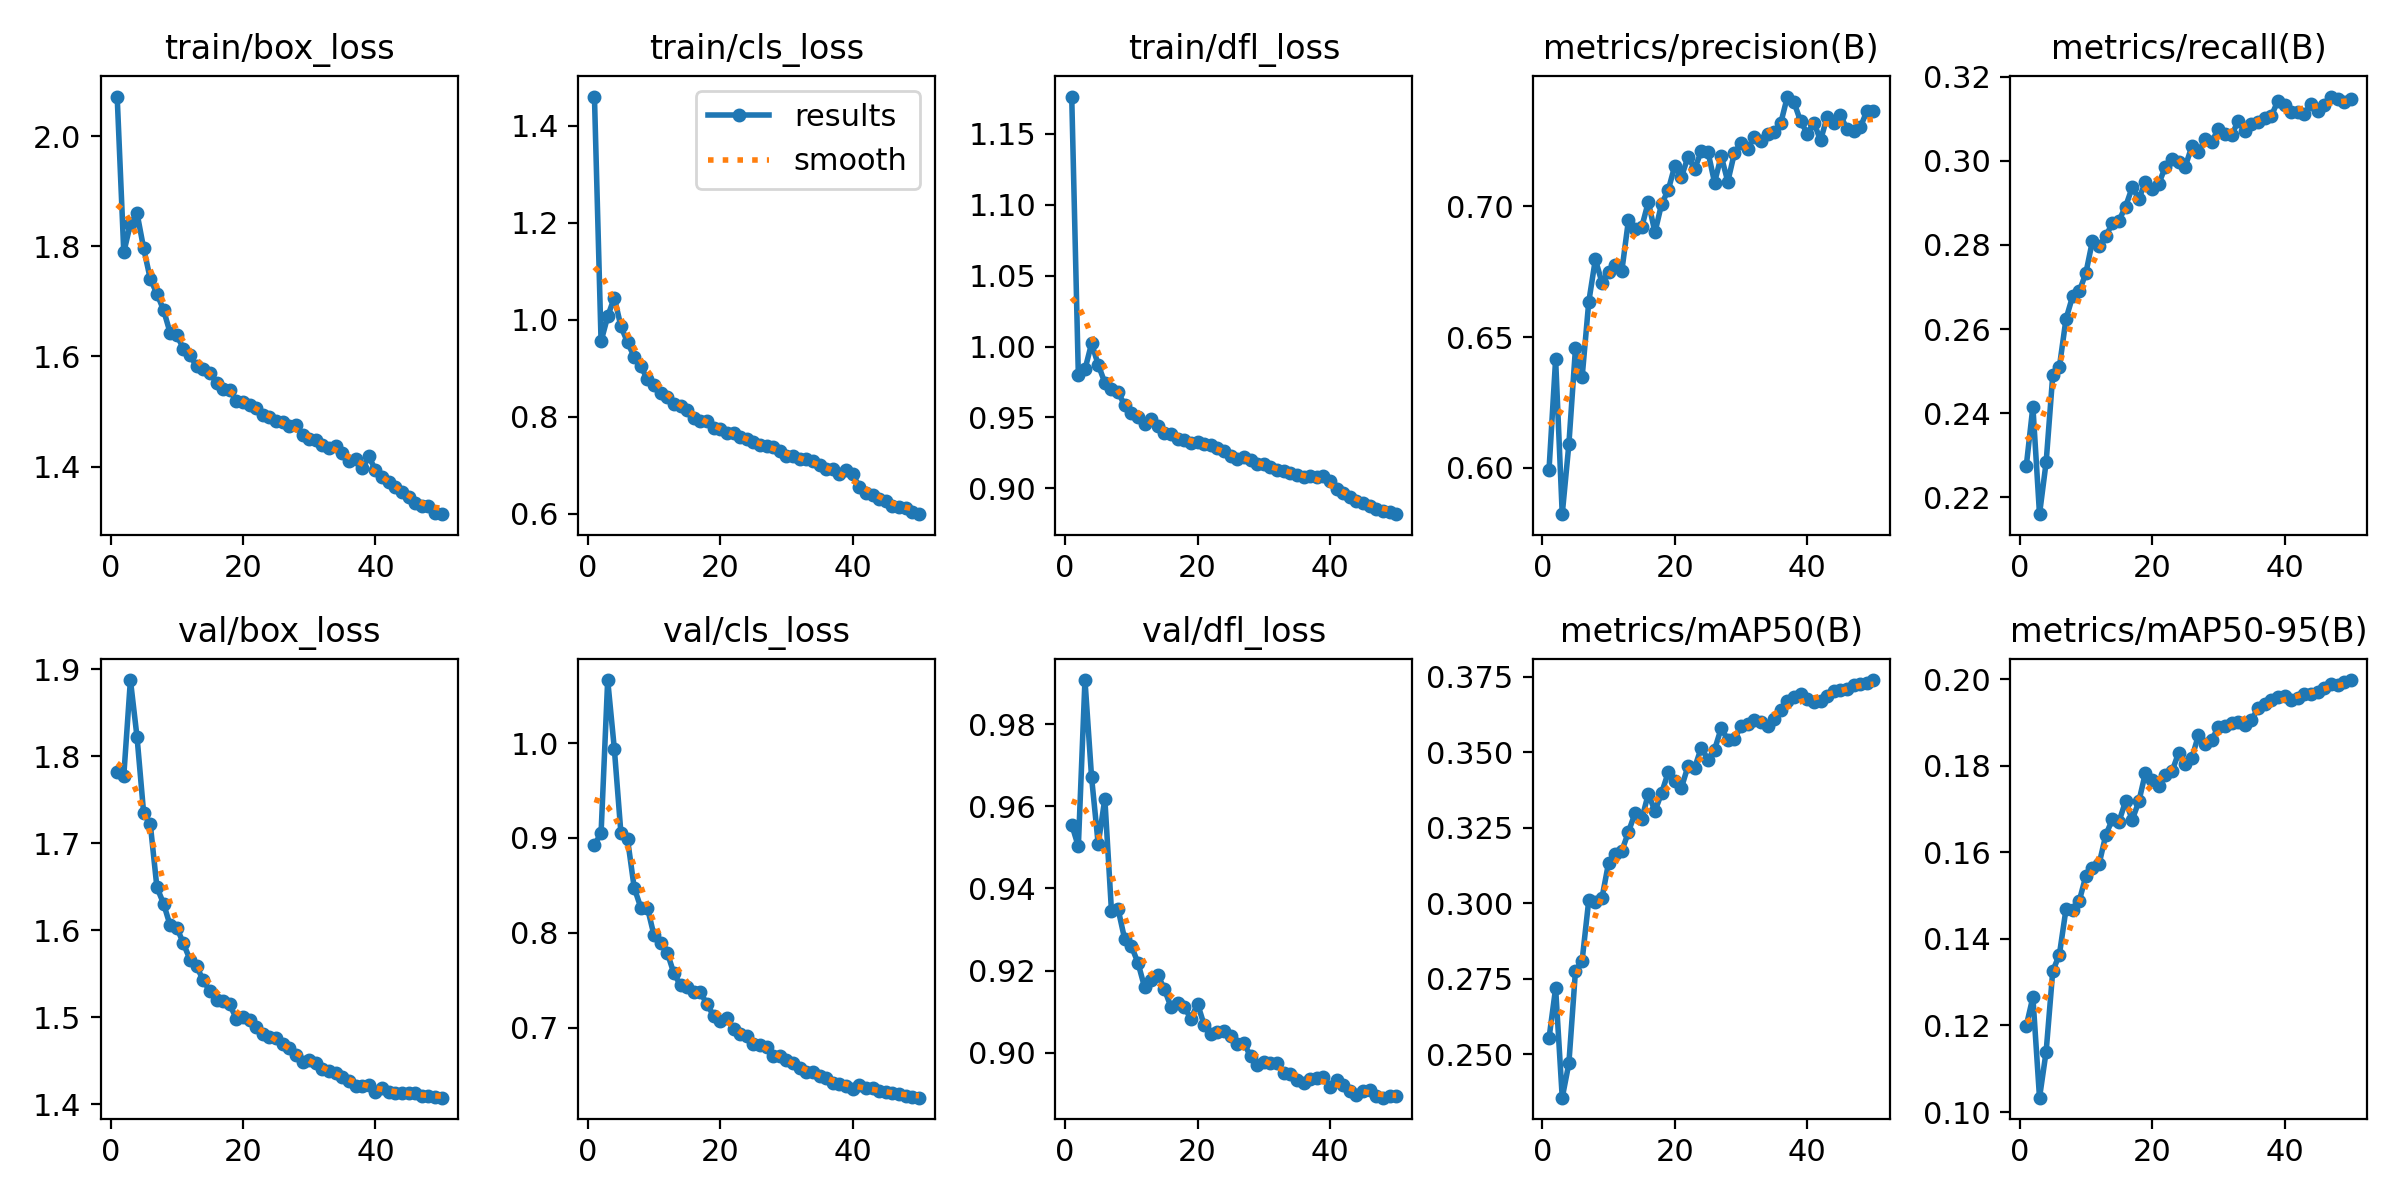

In [49]:
from IPython.display import Image
Image(filename='runs/detect/train/results.png')


# Compare fine-tuned YOLOv8 based face detector with face detector available in the following GitHub directory using the validation set of WIDER FACE dataset.
https://github.com/Yusepp/YOLOv8-Face

In [39]:
import cv2
from ultralytics import YOLO

model = YOLO('yolov8l_100e.pt')  # Trained weights
results = model('images/world_selfie.jpg', save=True, conf=0.1)

cv2.imwrite('world_selfie_output.jpg', results[0].plot())


image 1/1 /home/nikola/Documents/DeepLearning-Assignment-7-2/images/world_selfie.jpg: 384x640 300 Faces, 52.3ms
Speed: 1.6ms preprocess, 52.3ms inference, 8.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


True

In [ ]:
import matplotlib.pyplot as plt

img = cv2.imread('selfi2_output.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.title('Face Detection Result')
plt.show()

<Figure size 640x480 with 1 Axes>